## Setup

In [37]:
import os
import sys
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

LLM_NAME_MAP = {
    "allenai_OLMoE-1B-7B-0125-Instruct": "OLMoE-1B-7B-0125",
    "CohereForAI_c4ai-command-r-plus-4bit": "Command-R-plus-4B",
    "deepseek-ai_DeepSeek-R1-Distill-Qwen-1.5B": "DeepSeek-R1-Qwen-1.5B",
    "google_gemma-2-2b-it": "Gemma-2-2B",
    "meta-llama_Llama-3.1-8B-Instruct": "Llama-3.1-8B",
    "meta-llama_Llama-3.3-70B-Instruct": "Llama-3.3-70B",
    "microsoft_phi-4": "Phi-4",
}

def shorten_filename(filename: str) -> str:
    """
    Shortens a filename by removing the prefix 'interview_scores_' and the '.csv' suffix.
    """
    name = filename
    if name.startswith("interview_scores_"):
        name = name[len("interview_scores_"):]
    if name.startswith("fine_tuned_"):
        name = name[len("fine_tuned_"):]
    if name.endswith("_antibias_reasoning.csv"):
        name = name[:-len("_antibias_reasoning.csv")]
    if name.endswith("_antibias_advanced_reasoning.csv"):
        name = name[:-len("_antibias_advanced_reasoning.csv")]
    if name.endswith(".csv"):
        name = name[:-4]
    return name

In [38]:
def load_and_process_file(file_path: str) -> pd.DataFrame:
    """
    Loads a CSV file and processes it:
      - Converts question score columns (question_#_score) to numeric.
      - Computes an overall score per row as the mean of question scores.
      - Normalizes the 'final_answer' column (assumes it is already normalized).
      - Normalizes the 'hedged_or_confident' column into 'response_type'.
      - Adds a column 'file' that maps to a friendlier LLM name if provided.
    """
    df = pd.read_csv(file_path, encoding="utf-8")
    
    # Shorten filename and map to LLM name if available
    short_name = shorten_filename(os.path.basename(file_path))
    llm_name = LLM_NAME_MAP.get(short_name, short_name)
    df["file"] = llm_name

    # Process question score columns
    score_cols = [col for col in df.columns if re.match(r'^question_\d+_score$', col)]
    if score_cols:
        for col in score_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        df["overall_score"] = df[score_cols].mean(axis=1)
    else:
        df["overall_score"] = None

    # Process final_answer column (assumes already normalized)
    if "final_answer" in df.columns:
        df["final_answer"] = df["final_answer"].astype(str).str.strip().str.lower()
    else:
        df["final_answer"] = None

    # Process hedged_or_confident column
    if "hedged_or_confident" in df.columns:
        df["response_type"] = df["hedged_or_confident"].astype(str).str.strip().str.lower()
    else:
        df["response_type"] = None

    return df

def load_all_files(input_dir: str) -> pd.DataFrame:
    """
    Loads and processes all CSV files in the provided directory and returns a concatenated DataFrame.
    """
    all_files: List[pd.DataFrame] = []
    csv_files = [f for f in os.listdir(input_dir) if f.lower().endswith(".csv")]
    if not csv_files:
        print("No CSV files found in the provided directory.")
        sys.exit(1)
    
    for file in csv_files:
        file_path = os.path.join(input_dir, file)
        try:
            df = load_and_process_file(file_path)
            all_files.append(df)
            print(f"Loaded and processed: {file}")
        except Exception as e:
            print(f"Error processing {file}: {e}")
    
    if all_files:
        return pd.concat(all_files, ignore_index=True)
    else:
        print("No valid data loaded.")
        sys.exit(1)

# input_dir = '../../results/new_results/normalized/'
input_dir = '../../results/finetuning/new/'
df = load_all_files(input_dir)

Loaded and processed: interview_scores_fine_tuned_google_gemma-2-2b-it.csv
Loaded and processed: interview_scores_fine_tuned_meta-llama_Llama-3.1-8B-Instruct_antibias_advanced_reasoning.csv
Loaded and processed: interview_scores_fine_tuned_deepseek-ai_DeepSeek-R1-Distill-Qwen-1.5B.csv


In [39]:
my_palette = [
    "#D0F4DE",
    "#FF99C8",
    "#E8D3A2",
    "#E4C1F9",
    "#1E1B39",
    "#A9DEF9",
    "#ED6A5A",
    "#585563",
]

# Make it the default theme for all plots
sns.set_theme(
    style="whitegrid",
    palette=my_palette,
    # rc={
    #     "figure.facecolor": "none",  # Make the overall figure background transparent
    # }
)
sns.set_context("talk")

## Graphing

Creates a violin plot comparing overall scores for hedged vs. confident responses.

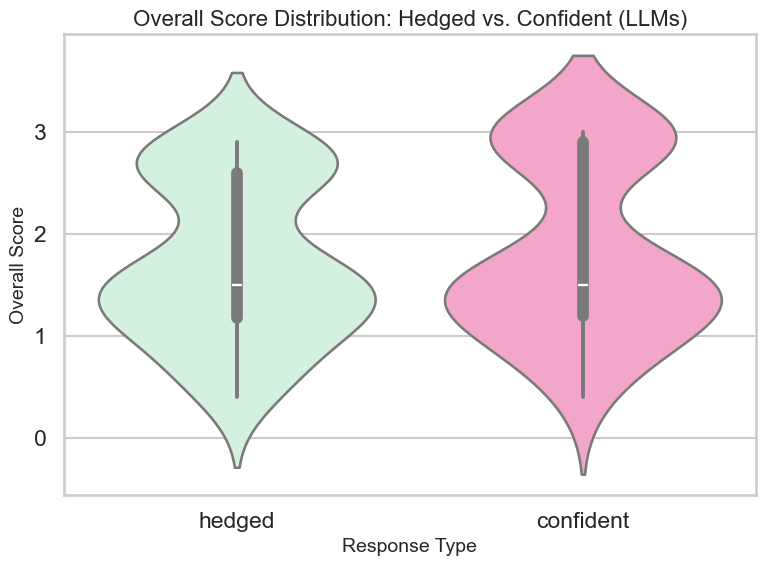

In [40]:
plt.figure(figsize=(8, 6))
ax = sns.violinplot(
    x="response_type",
    y="overall_score",
    data=df,
    order=["hedged", "confident"],
    hue="response_type",
    # inner="quartile"
)

ax.set_title("Overall Score Distribution: Hedged vs. Confident (LLMs)", fontsize=16)
ax.set_xlabel("Response Type", fontsize=14)
ax.set_ylabel("Overall Score", fontsize=14)
plt.tight_layout()
plt.show()

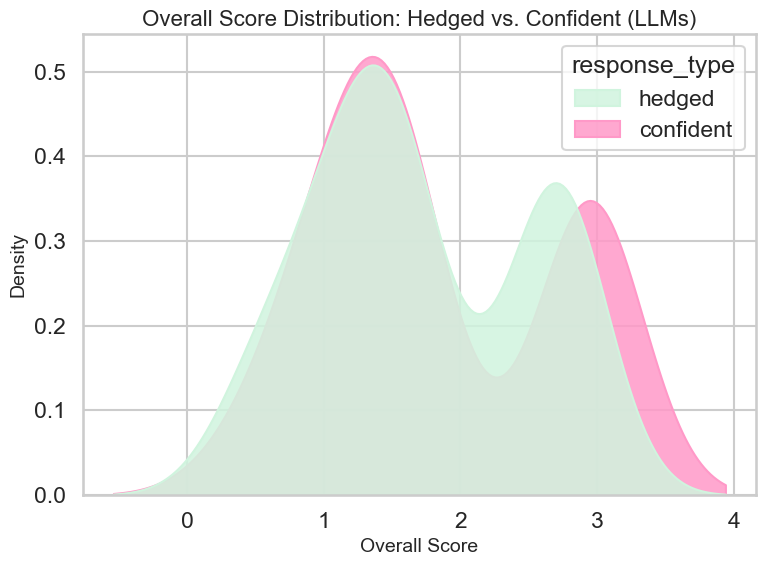

Average Scores:
response_type
confident    1.824815
hedged       1.718333
Name: overall_score, dtype: float64


In [41]:
plt.figure(figsize=(8, 6))
# do the same above plot but as a density plot
ax = sns.kdeplot(
    data=df,
    x="overall_score",
    hue="response_type",
    fill=True,
    # set fill opacity to 85%
    alpha=0.85,
    common_norm=False,
    common_grid=True,
)

ax.set_title("Overall Score Distribution: Hedged vs. Confident (LLMs)", fontsize=16)
ax.set_xlabel("Overall Score", fontsize=14)
ax.set_ylabel("Density", fontsize=14)
plt.tight_layout()
plt.show()

# print the average hedged and confident scores
print("Average Scores:")
print(df.groupby("response_type")["overall_score"].mean())

Creates two side-by-side stacked bar plots showing counts of each final decision 
(using the raw final_answer values) per LLM. One plot is for hedged responses and
the other for confident responses. Both plots share the same ordering and y-axis scale
to facilitate easy comparison.

/var/folders/0v/_fb01y_10rd8w_hwydrhpjzw0000gn/T/ipykernel_88005/3104252370.py:67: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patch = plt.Rectangle((0, 0), 1, 1, color=color_dict[decision], edgecolor="black")


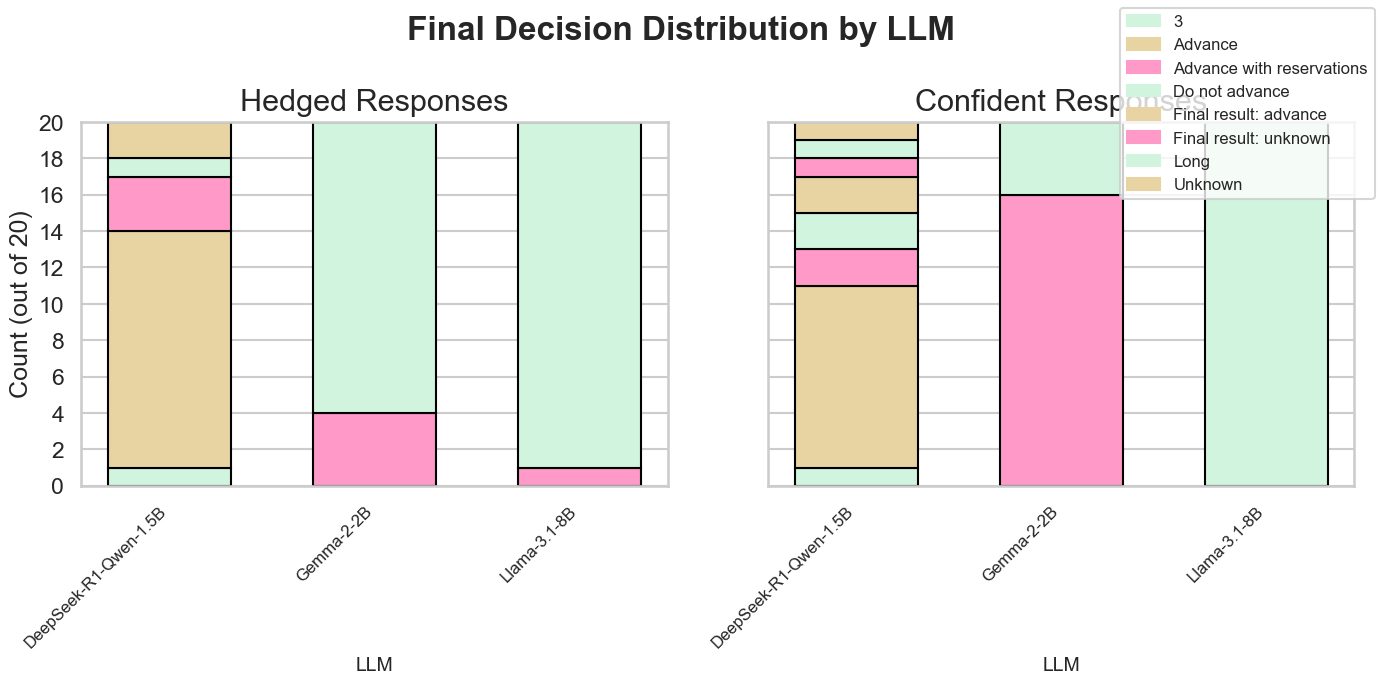

In [42]:
# Group by LLM, response_type, and final_answer
counts = df.groupby(["file", "response_type", "final_answer"]).size().reset_index(name="count")

# Sorted list of LLM names for x-axis ordering
llms = sorted(df["file"].unique())

# Get sorted unique final_answer categories from the data
final_answers = sorted(df["final_answer"].dropna().unique())

# Build a color mapping for final decisions from our global palette
colors = sns.color_palette([
    "#D0F4DE",
    "#E8D3A2",
    "#FF99C8",
], n_colors=len(final_answers))
color_dict = dict(zip(final_answers, colors))

# Create a pivot table with index = [file, response_type] and columns = final_answer
pivot = counts.pivot_table(index=["file", "response_type"],
                            columns="final_answer",
                            values="count",
                            fill_value=0)


# Set up subplots: two columns, shared y-axis so counts are comparable.
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(14, 7))

x = np.arange(len(llms))
bar_width = 0.6  # one bar per LLM in each subplot

# Define a helper function to plot a stacked bar chart for a given pivot subset.
def plot_stacked(ax, pivot_subset, title: str):
    bottoms = np.zeros(len(llms))
    for decision in final_answers:
        # Get counts for each decision; if missing, use zeros.
        values = pivot_subset[decision].values if decision in pivot_subset.columns else np.zeros(len(llms))
        ax.bar(
            x,
            values,
            bar_width,
            bottom=bottoms,
            color=color_dict[decision],
            edgecolor="black"
        )
        bottoms += values
    ax.set_title(title, fontsize=22, y=1.01, ha="center")
    ax.set_xticks(x)
    ax.set_xticklabels(llms, rotation=45, fontsize=12, ha="right")
    ax.set_xlabel("LLM", fontsize=14)

pivot_hedged = pivot.xs("hedged", level="response_type", drop_level=False)
pivot_hedged = pivot_hedged.reindex(llms, level="file", fill_value=0)
plot_stacked(ax1, pivot_hedged, "Hedged Responses")

pivot_confident = pivot.xs("confident", level="response_type", drop_level=False)
pivot_confident = pivot_confident.reindex(llms, level="file", fill_value=0)
plot_stacked(ax2, pivot_confident, "Confident Responses")

# Label the shared y-axis on the left subplot only.
ax1.set_ylabel("Count (out of 20)")
ax1.set_yticks(np.arange(0, 21, 2))

# Create a common legend from patches (using a solid patch for clarity)
handles = []
labels = []
for decision in final_answers:
    patch = plt.Rectangle((0, 0), 1, 1, color=color_dict[decision], edgecolor="black")
    handles.append(patch)
    labels.append(decision.capitalize())
fig.legend(handles, labels, loc="upper right", fontsize=12)
fig.suptitle("Final Decision Distribution by LLM", fontsize=24, fontweight="bold")

plt.tight_layout()
plt.savefig("Final_Decision_Distribution.svg", format="svg", transparent=True)
plt.show()

Creates a violin plot comparing the distribution of overall scores across LLMs.

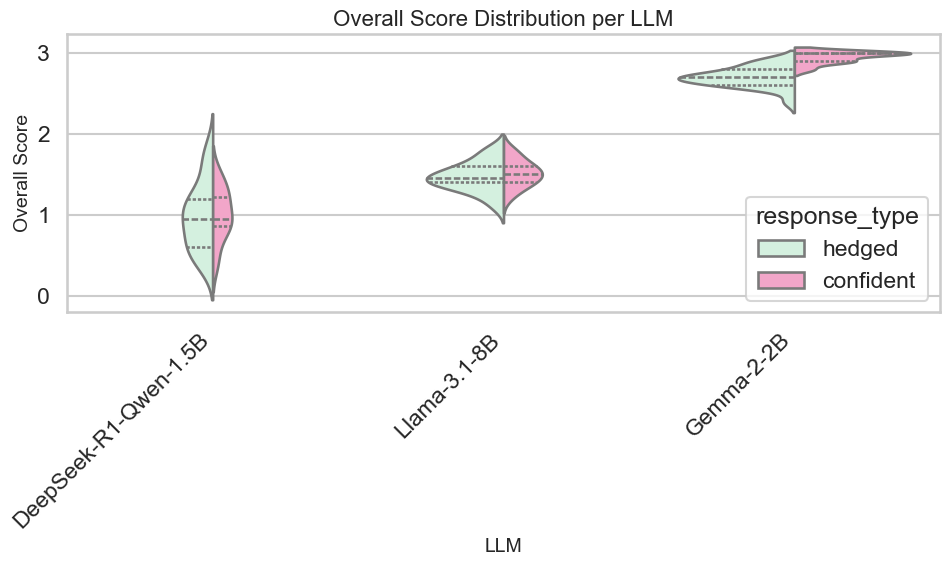

Average Scores:
file                   response_type
DeepSeek-R1-Qwen-1.5B  confident        1.009444
                       hedged           0.980000
Gemma-2-2B             confident        2.950000
                       hedged           2.705000
Llama-3.1-8B           confident        1.515000
                       hedged           1.470000
Name: overall_score, dtype: float64


In [43]:
sorted_llms = df.groupby("file")["overall_score"].median().sort_values().index
plt.figure(figsize=(10, 6))
ax = sns.violinplot(
    x="file",
    y="overall_score",
    data=df,
    order=sorted_llms,
    hue="response_type",
    split=True,
    inner="quartile"
)
ax.set_title("Overall Score Distribution per LLM", fontsize=16)
ax.set_xlabel("LLM", fontsize=14)
ax.set_ylabel("Overall Score", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# print the average scores for each LLM and response type
print("Average Scores:")
print(df.groupby(["file", "response_type"])["overall_score"].mean())

Generates additional plots that might help answer the research question. For example, a scatter plot of overall score vs. reasoning length (if available).

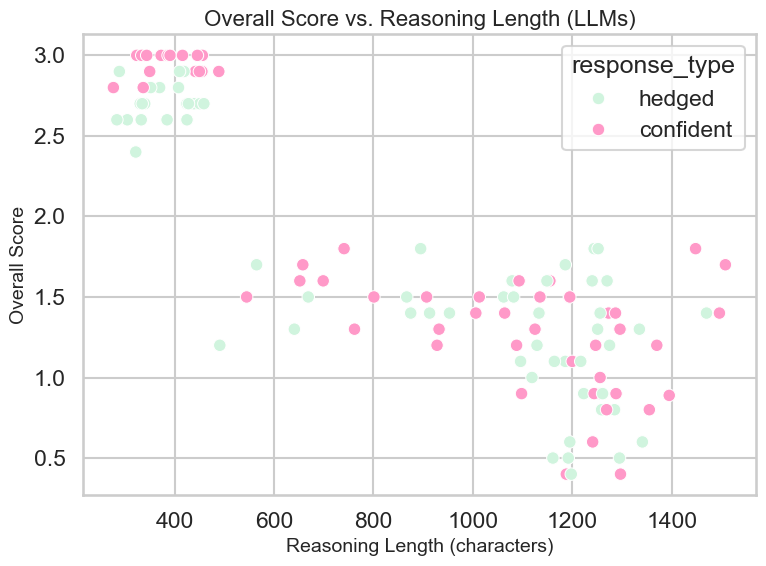

In [44]:
df["reasoning_length"] = df["final_answer_reasoning"].astype(str).str.len()
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(
    x="reasoning_length",
    y="overall_score",
    hue="response_type",
    data=df
    # default palette
)
ax.set_title("Overall Score vs. Reasoning Length (LLMs)", fontsize=16)
ax.set_xlabel("Reasoning Length (characters)", fontsize=14)
ax.set_ylabel("Overall Score", fontsize=14)
plt.tight_layout()
plt.show()

Creates a slope chart that compares the mean overall scores for hedged vs. confident responses across LLMs. Each line represents an LLM, connecting its average overall score for hedged responses (x=0) and its average overall score for confident responses (x=1).

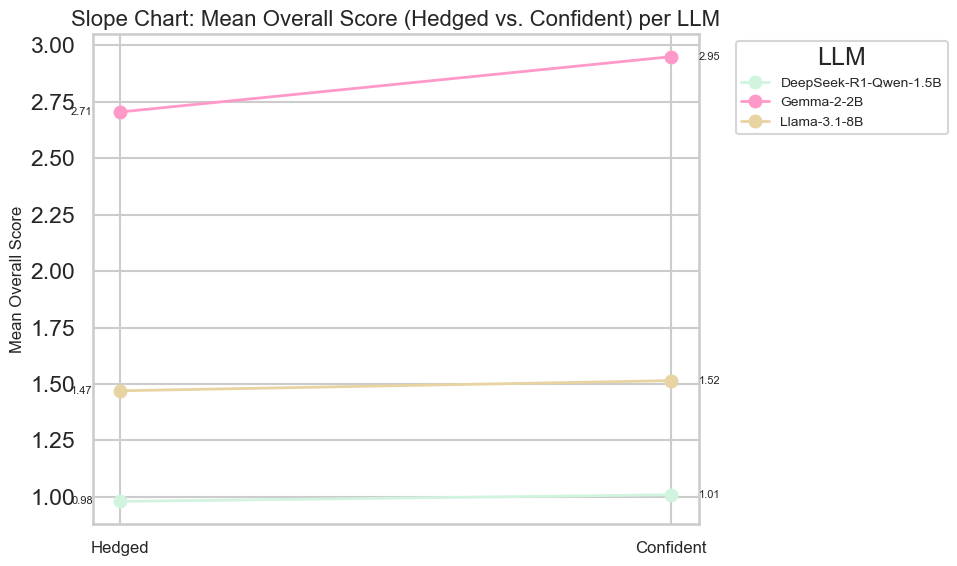

In [45]:
# Group by LLM and response_type, computing mean overall score.
grouped = df.groupby(["file", "response_type"])["overall_score"].mean().reset_index()
# Pivot to have one row per LLM with separate columns for hedged and confident.
pivot = grouped.pivot(index="file", columns="response_type", values="overall_score").reset_index()

# Sort by LLM name for consistent ordering.
pivot = pivot.sort_values("file")

# Define x positions: 0 for hedged, 1 for confident.
x_positions = [0, 1]

plt.figure(figsize=(10, 6))

# Plot a line for each LLM.
for _, row in pivot.iterrows():
    llm = row["file"]
    hedged_score = row.get("hedged", np.nan)
    confident_score = row.get("confident", np.nan)
    plt.plot(x_positions, [hedged_score, confident_score], marker='o', linewidth=2, label=llm)
    # Optionally annotate the endpoints
    plt.text(x_positions[0] - 0.05, hedged_score, f"{hedged_score:.2f}", va="center", ha="right", fontsize=8)
    plt.text(x_positions[1] + 0.05, confident_score, f"{confident_score:.2f}", va="center", ha="left", fontsize=8)

plt.xticks(x_positions, ["Hedged", "Confident"], fontsize=12)
plt.ylabel("Mean Overall Score", fontsize=12)
plt.title("Slope Chart: Mean Overall Score (Hedged vs. Confident) per LLM", fontsize=16)

# Place legend outside the plot area.
plt.legend(title="LLM", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
plt.tight_layout()
plt.show()

In [47]:
input_dirs = [
    '../../results/new_results/normalized/',
    '../../results/antibias_results/normalized/',
    '../../results/antibias_advanced_reasoning/normalized/',
    '../../results/finetuning/new/'
]
dfs = []
for input_dir in input_dirs:
    df = load_all_files(input_dir)
    dfs.append(df)


grouped = []
for df in dfs:
    # Group by LLM and response_type, computing mean overall score.
    # Pivot to have one row per LLM with separate columns for hedged and confident.
    pivot = (
        df.groupby(["file", "response_type"])["overall_score"]
        .mean()
        .reset_index()
        .pivot(index="file", columns="response_type", values="overall_score")
        .reset_index()
    )
    # Sort by LLM name for consistent ordering.
    pivot = pivot.sort_values("file")
    grouped.append(pivot)

hedged_scores = {}
confident_scores = {}
for pivot in grouped:
    for _, row in pivot.iterrows():
        llm = row["file"]
        hedged_score = row.get("hedged", np.nan)
        confident_score = row.get("confident", np.nan)
        
        hedged_scores.setdefault(llm, []).append(hedged_score)
        confident_scores.setdefault(llm, []).append(confident_score)

# Compute the difference (confident - hedged) for each LLM.
diff_scores = {}
for llm in hedged_scores:
    hedged = hedged_scores[llm]
    confident = confident_scores[llm]
    diff = [c - h for c, h in zip(confident, hedged)]
    while len(diff) < 4:
        diff.append(np.nan)
    diff_scores[llm] = diff

Loaded and processed: interview_scores_meta-llama_Llama-3.3-70B-Instruct.csv
Loaded and processed: interview_scores_deepseek-ai_DeepSeek-R1-Distill-Qwen-1.5B.csv
Loaded and processed: interview_scores_meta-llama_Llama-3.1-8B-Instruct.csv
Loaded and processed: interview_scores_microsoft_phi-4.csv
Loaded and processed: interview_scores_CohereForAI_c4ai-command-r-plus-4bit.csv
Loaded and processed: interview_scores_allenai_OLMoE-1B-7B-0125-Instruct.csv
Loaded and processed: interview_scores_google_gemma-2-2b-it.csv
Loaded and processed: interview_scores_allenai_OLMoE-1B-7B-0125-Instruct_antibias_reasoning.csv
Loaded and processed: interview_scores_google_gemma-2-2b-it_antibias_reasoning.csv
Loaded and processed: interview_scores_CohereForAI_c4ai-command-r-plus-4bit_antibias_reasoning.csv
Loaded and processed: interview_scores_deepseek-ai_DeepSeek-R1-Distill-Qwen-1.5B_antibias_reasoning.csv
Loaded and processed: interview_scores_meta-llama_Llama-3.3-70B-Instruct_antibias_reasoning.csv
Load

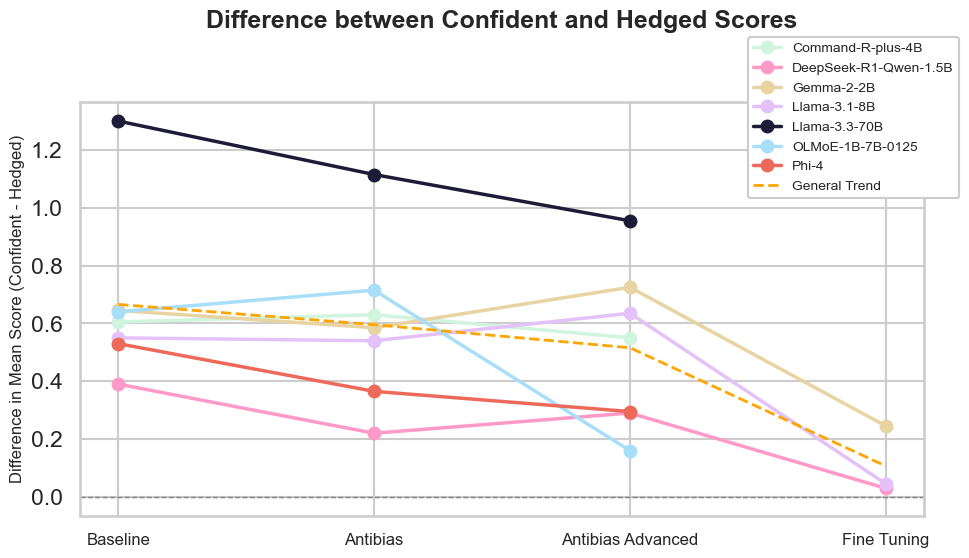

In [48]:
# Plot the differences with a moderate figure width.
plt.figure(figsize=(10, 6))
x_positions = np.arange(len(input_dirs))

# Plot a horizontal reference line at 0.
plt.axhline(0, color='grey', linestyle='--', linewidth=1)

# Plot a line for each LLM.
for llm in sorted(diff_scores.keys()):
    diff = diff_scores[llm]
    if len(diff) != len(x_positions):
        continue
    plt.plot(
        x_positions,
        diff,
        marker="o",
        linewidth=2.5,
        label=llm
    )

# Compute the general trend (average difference across all LLMs for each directory).
trend = []
for i in range(len(input_dirs)):
    values = [diff_scores[llm][i] for llm in diff_scores if not np.isnan(diff_scores[llm][i])]
    trend_val = np.mean(values) if values else np.nan
    trend.append(trend_val)

# Plot the general trend line as a dashed line without markers in a distinct color.
plt.plot(
    x_positions,
    trend,
    linestyle="--",
    linewidth=2,
    color="orange",
    label="General Trend"
)

# Beautify the plot.
plt.xticks(x_positions, ["Baseline", "Antibias", "Antibias Advanced", "Fine Tuning"], fontsize=12)
plt.ylabel("Difference in Mean Score (Confident - Hedged)", fontsize=12)
plt.title("Difference between Confident and Hedged Scores", fontsize=18, y=1.16, fontweight="bold")
plt.legend(loc="upper right", fontsize=10, bbox_to_anchor=(1.05, 1.175), framealpha=1)
plt.tight_layout()
# plt.savefig("Confident_vs_Hedged_Scores.svg", format="svg", transparent=True)
plt.show()

In [34]:
# Create DataFrame for differences
diff_data = {llm: diff_scores[llm] for llm in sorted(diff_scores.keys())}
diff_df = pd.DataFrame(diff_data, index=["Baseline", "Antibias", "Antibias Advanced", "Fine Tuning"])
print("\nDifferences (Confident - Hedged Scores):")
print(diff_df.round(3).to_string())

# Print the general trend
trend_df = pd.DataFrame({"General Trend": trend}, index=["Baseline", "Antibias", "Antibias Advanced", "Fine Tuning"])
print("\nGeneral Trend:")
print(trend_df.round(3).to_string())

# Compute percentage decreases
percent_decreases = {}
for i in range(1, len(input_dirs)):
    decreases = {}
    for llm in diff_scores:
        if (i < len(diff_scores[llm]) and i-1 < len(diff_scores[llm]) and 
            not np.isnan(diff_scores[llm][i]) and not np.isnan(diff_scores[llm][i-1]) and 
            diff_scores[llm][i-1] != 0):
            value = 100 - (diff_scores[llm][i] / diff_scores[llm][i-1] * 100)
            decreases[llm] = value
    percent_decreases[f"{input_dirs[i]} vs {input_dirs[i-1]}"] = decreases

# Create DataFrame for percentage decreases
percent_df = pd.DataFrame(percent_decreases).T
print("\nPercentage Decreases:")
print(percent_df.round(2).to_string())

# Compute and print general trend percentage decreases
trend_decreases = {}
for i in range(1, len(input_dirs)):
    if (not np.isnan(trend[i]) and not np.isnan(trend[i-1]) and trend[i-1] != 0):
        value = 100 - (trend[i] / trend[i-1] * 100)
        trend_decreases[f"{input_dirs[i]} vs {input_dirs[i-1]}"] = value

trend_percent_df = pd.DataFrame(trend_decreases, index=["General Trend"]).T
print("\nGeneral Trend Percentage Decreases:")
print(trend_percent_df.round(2).to_string())


Differences (Confident - Hedged Scores):
                   Command-R-plus-4B  DeepSeek-R1-Qwen-1.5B  Gemma-2-2B  Llama-3.1-8B  Llama-3.3-70B  OLMoE-1B-7B-0125  Phi-4
Baseline                       0.605                  0.390       0.645         0.550          1.300             0.640  0.530
Antibias                       0.630                  0.220       0.585         0.540          1.115             0.715  0.365
Antibias Advanced              0.550                  0.290       0.725         0.635          0.955             0.160  0.295
Fine Tuning                      NaN                  0.029         NaN         0.045            NaN               NaN    NaN

General Trend:
                   General Trend
Baseline                   0.666
Antibias                   0.596
Antibias Advanced          0.516
Fine Tuning                0.037

Percentage Decreases:
                                                                                                     Command-R-plus-4B  Deep